In [54]:
import torch
import scanpy as sc

from sklearn.metrics import adjusted_rand_score, silhouette_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
from scvi.model import SCVI
from scripts import constants
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
dataset = "zheng_2017"

In [3]:
adata = sc.read_h5ad(
    os.path.join(
        constants.DEFAULT_DATA_PATH,
        f"{dataset}/preprocessed/adata_top_2000_genes.h5ad",
    )
)

target_adata = adata[adata.obs["condition"] != "healthy"].copy()
background_adata = adata[adata.obs["condition"] == "healthy"].copy()

target_trans_adata = target_adata.copy()
background_trans_adata = background_adata.copy()

SCVI.setup_anndata(target_adata, layer="count")
SCVI.setup_anndata(target_trans_adata)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["count"]                                               
INFO     Successfully registered anndata object containing 12399 cells, 2000 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 1

In [4]:
assert target_adata.uns["_scvi"]["data_registry"]["X"]["attr_key"] == "count"
assert target_trans_adata.uns["_scvi"]["data_registry"]["X"]["attr_key"] == "None"

In [5]:
seeds = [123, 42, 789, 46, 999]
latent_size = 2

contrastive_vi_latent_representations = [
    np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            f"{dataset}/contrastiveVI/latent_{latent_size}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]

fixed_epoch_contrastive_vi_latent_representations = [
    np.load(
        os.path.join(
            "/projects/leelab/contrastiveVI/results-fixed-epochs",
            f"{dataset}/contrastiveVI/latent_{latent_size}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]

learned_lib_contrastive_vi_latent_representations = [
    np.load(
        os.path.join(
            "/projects/leelab/contrastiveVI/results-learned-lib-size",
            f"{dataset}/contrastiveVI/latent_{latent_size}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]

sc_vi_latent_representations = [
    np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            f"{dataset}/scVI/latent_{latent_size}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]

learned_lib_sc_vi_latent_representations = [
    np.load(
        os.path.join(
            "/projects/leelab/contrastiveVI/results-learned-lib-size",
            f"{dataset}/scVI/latent_{latent_size}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]

tc_contrastive_vi_latent_representations = [
    np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            f"{dataset}/TC_contrastiveVI/latent_{latent_size}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]

mmd_contrastive_vi_latent_representations = [
    np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            f"{dataset}/mmd_contrastiveVI/latent_{latent_size}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]

cvae_latent_representations = [
    np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            f"{dataset}/cVAE/latent_{latent_size}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]

fixed_epoch_cvae_latent_representations = [
    np.load(
        os.path.join(
            "/projects/leelab/contrastiveVI/results-fixed-epochs",
            f"{dataset}/cVAE/latent_{latent_size}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]

cplvm_latent_representations = [
    np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            f"{dataset}/CPLVM/latent_{latent_size}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]

pcpca_latent_representations = np.load(
    os.path.join(
        constants.DEFAULT_RESULTS_PATH,
        f"{dataset}/PCPCA/latent_{latent_size}/latent_representations.npy",
    )
)
pcpca_latent_representations = [pcpca_latent_representations]

cpca_latent_representations = np.load(
    os.path.join(
        constants.DEFAULT_RESULTS_PATH,
        f"{dataset}/cPCA/latent_{latent_size}/latent_representations.npy",
    )
)
cpca_latent_representations = [cpca_latent_representations]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.04it/s]


In [6]:
salient_representation_dict = {
    "scVI" : sc_vi_latent_representations,
    "learned_lib_scVI": learned_lib_sc_vi_latent_representations,
    "cPCA": cpca_latent_representations,
    "PCPCA": pcpca_latent_representations,
    "early_stopped_cVAE": cvae_latent_representations,
    "fixed_epoch_cVAE": fixed_epoch_cvae_latent_representations,
    "CPLVM": cplvm_latent_representations,
    "early_stopped_contrastiveVI": contrastive_vi_latent_representations,
    "fixed_epoch_contrastiveVI": fixed_epoch_contrastive_vi_latent_representations,
    "learned_lib_contrastiveVI": learned_lib_contrastive_vi_latent_representations,
    "tc_contrastiveVI": tc_contrastive_vi_latent_representations,
    "mmd_contrastiveVI": mmd_contrastive_vi_latent_representations,
}

In [101]:
labels = target_adata.obs["condition"]
one_hot_labels = LabelEncoder().fit_transform(labels)

silhouette_results_dict = {}
ari_results_dict = {}
nmi_results_dict = {}
latent_clusters_dict = {}
for model_name, latent_list in salient_representation_dict.items():
    print(f"Evaluating {model_name} representations...")
    silhouette_results = []
    ari_results = []
    nmi_results = []
    latent_clusters = []
    
    for latent in tqdm(latent_list):
        latent_clustering = KMeans(n_clusters=2, random_state=123).fit(latent).labels_
        silhouette_results.append(silhouette_score(latent, one_hot_labels))
        ari_results.append(adjusted_rand_score(one_hot_labels, latent_clustering))
        nmi_results.append(adjusted_mutual_info_score(one_hot_labels, latent_clustering))
        latent_clusters.append(latent_clustering)
        
    silhouette_results_dict[model_name] = silhouette_results
    ari_results_dict[model_name] = ari_results
    nmi_results_dict[model_name] = nmi_results
    latent_clusters_dict[model_name] = latent_clusters
    
print("Done!")

Evaluating scVI representations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.04s/it]


Evaluating learned_lib_scVI representations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.82s/it]


Evaluating cPCA representations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.03s/it]


Evaluating PCPCA representations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  9.00s/it]


Evaluating early_stopped_cVAE representations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.29s/it]


Evaluating fixed_epoch_cVAE representations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.04s/it]


Evaluating CPLVM representations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.19s/it]


Evaluating early_stopped_contrastiveVI representations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.05s/it]


Evaluating fixed_epoch_contrastiveVI representations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.26s/it]


Evaluating learned_lib_contrastiveVI representations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.21s/it]


Evaluating tc_contrastiveVI representations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  6.87s/it]


Evaluating mmd_contrastiveVI representations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  6.90s/it]

Done!


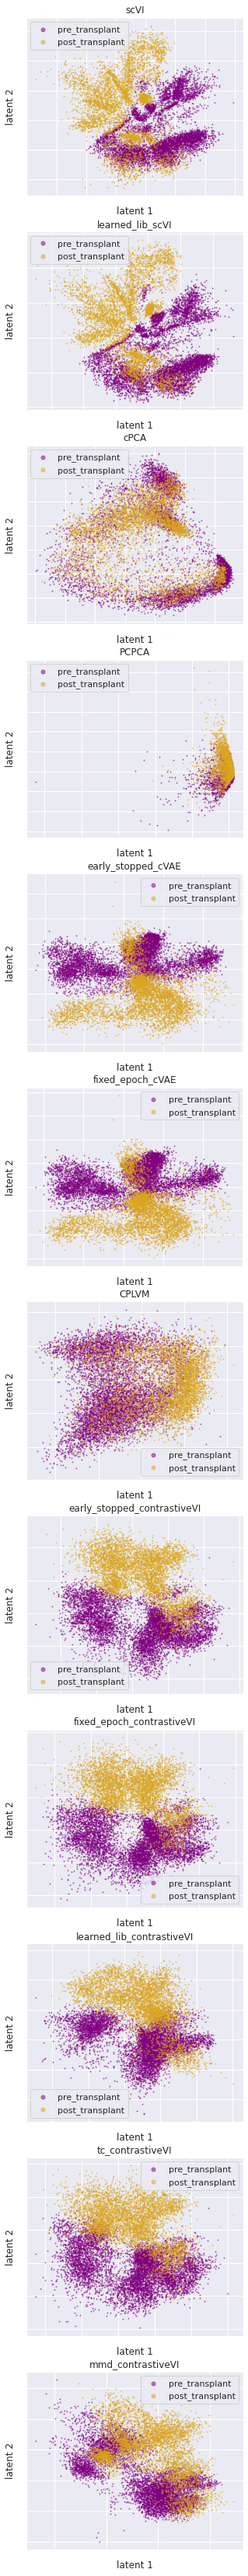

In [102]:
seed_index = 4
two_dim_dict = {
    "scVI" : sc_vi_latent_representations[seed_index],
    "learned_lib_scVI": learned_lib_sc_vi_latent_representations[seed_index],
    "cPCA": cpca_latent_representations[0],
    "PCPCA": pcpca_latent_representations[0],
    "early_stopped_cVAE": cvae_latent_representations[seed_index],
    "fixed_epoch_cVAE": fixed_epoch_cvae_latent_representations[seed_index],
    "CPLVM": cplvm_latent_representations[seed_index],
    "early_stopped_contrastiveVI": contrastive_vi_latent_representations[seed_index],
    "fixed_epoch_contrastiveVI": fixed_epoch_contrastive_vi_latent_representations[seed_index],
    "learned_lib_contrastiveVI": learned_lib_contrastive_vi_latent_representations[seed_index],
    "tc_contrastiveVI": tc_contrastive_vi_latent_representations[seed_index],
    "mmd_contrastiveVI": mmd_contrastive_vi_latent_representations[seed_index],
}
xlabel = "latent 1"
ylabel = "latent 2"
if latent_size > 2:
    for key, rep in two_dim_dict.items():
        two_dim_dict[key] = PCA().fit_transform(rep)[:, :2]
    xlabel = "PC1"
    ylabel = "PC2"

target_labels = target_adata.obs["condition"]
fix, axes = plt.subplots(figsize=(5, 5 * len(two_dim_dict)), ncols=1, nrows=len(two_dim_dict))
colors = ["purple", "goldenrod"]

ax_counter = 0
for model_name, rep in two_dim_dict.items():
    ax = axes[ax_counter]
    for i, label in enumerate(target_labels.unique()):
        ax.scatter(
            rep[:, 0][target_labels == label],
            rep[:, 1][target_labels == label],
            s=1,
            label=label,
            color=colors[i],
            alpha=0.5,
        )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.legend(markerscale=5)
    ax.set_title(model_name)
    ax_counter += 1

Text(0.5, 1.0, 'Clustering Performance')

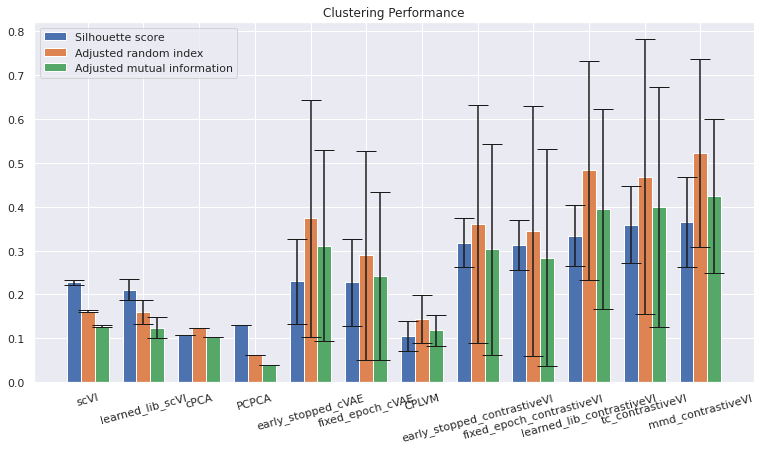

In [103]:
model_labels = [model_name for model_name in salient_representation_dict.keys()]
width = 0.25  # Bar width
x = np.arange(len(model_labels))
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(
    x,
    [np.mean(silhouette_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[np.std(silhouette_results_dict[model_label]) for model_label in model_labels],
    capsize=10,
    label="Silhouette score",
)
ax.bar(
    x + width,
    [np.mean(ari_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[np.std(ari_results_dict[model_label]) for model_label in model_labels],
    capsize=10,
    label="Adjusted random index",
)
ax.bar(
    x + width * 2,
    [np.mean(nmi_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[np.std(nmi_results_dict[model_label]) for model_label in model_labels],
    capsize=10,
    label="Adjusted mutual information",
)

ax.set_xticks(x + width)
ax.set_xticklabels(model_labels, rotation=15)
ax.legend()
ax.set_title("Clustering Performance")

In [104]:
ari_results_dict["learned_lib_contrastiveVI"]

[0.7045433814031377,
 0.7629473213567991,
 0.19637324784039123,
 0.5753920211175089,
 0.17529729141137004]

In [105]:
silhouette_results_dict["learned_lib_contrastiveVI"]

[0.40371412, 0.3486759, 0.2497153, 0.41206425, 0.25621077]

In [106]:
learned_lib_contrastive_vi_models = [
    torch.load(
        os.path.join(
            "/projects/leelab/contrastiveVI/results-learned-lib-size",
            # constants.DEFAULT_RESULTS_PATH,
            f"zheng_2017/contrastiveVI/latent_{latent_size}/{seed}/model.ckpt"),
        map_location="cpu",
    )
    for seed in tqdm(seeds)
]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:10<00:00, 14.12s/it]


In [107]:
history_list = [
    model.history
    for model in learned_lib_contrastive_vi_models
]
elbo_history_list = []
for history in history_list:
    elbo_train = history["elbo_train"].rename(columns={"elbo_train": "elbo"})
    elbo_train["elbo"] = elbo_train["elbo"].astype(float)
    elbo_train["dataset"] = "train"
    elbo_train = elbo_train.reset_index()
    
    elbo_validation = history["elbo_validation"].rename(columns={"elbo_validation": "elbo"})
    elbo_validation["elbo"] = elbo_validation["elbo"].astype(float)
    elbo_validation["dataset"] = "validation"
    elbo_validation = elbo_validation.reset_index()
    
    elbo_history = pd.concat([elbo_train, elbo_validation]).reset_index(drop=True)
    elbo_history["log_elbo"] = np.log(elbo_history["elbo"])
    elbo_history_list.append(elbo_history)

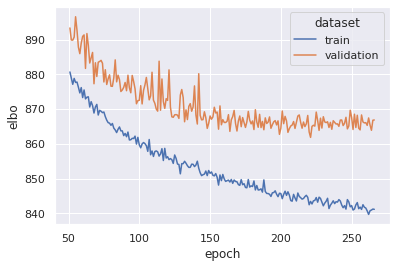

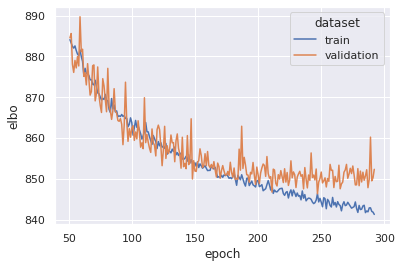

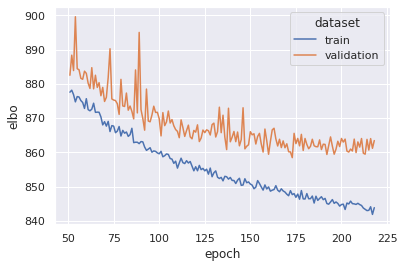

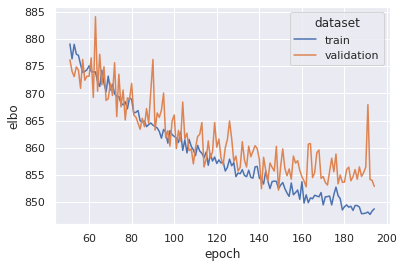

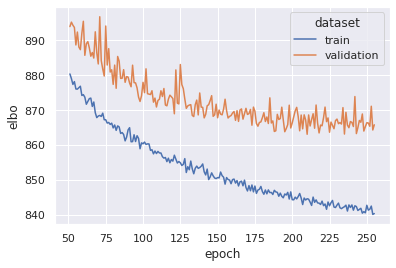

In [108]:
for elbo_history in elbo_history_list:
    plt.figure()
    sns.lineplot(
        data=elbo_history[elbo_history["epoch"] > 50],
        x="epoch",
        y="elbo",
        hue="dataset",
    )

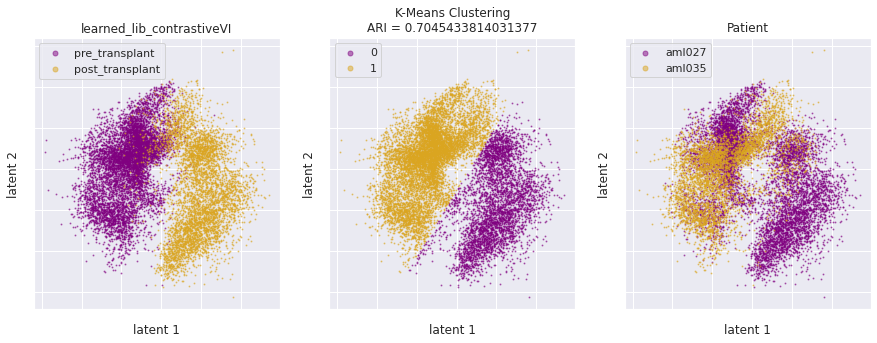

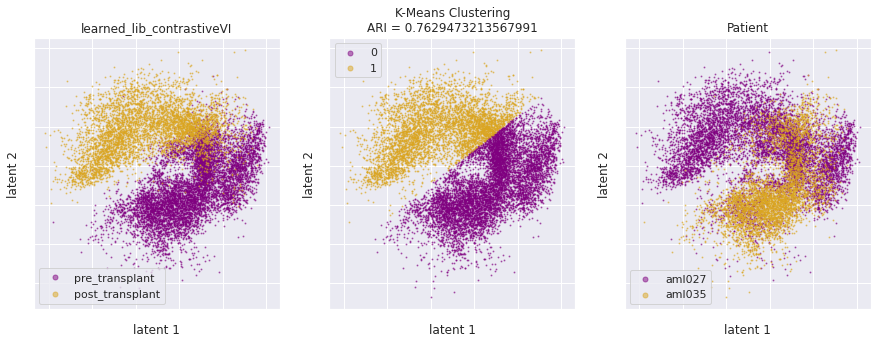

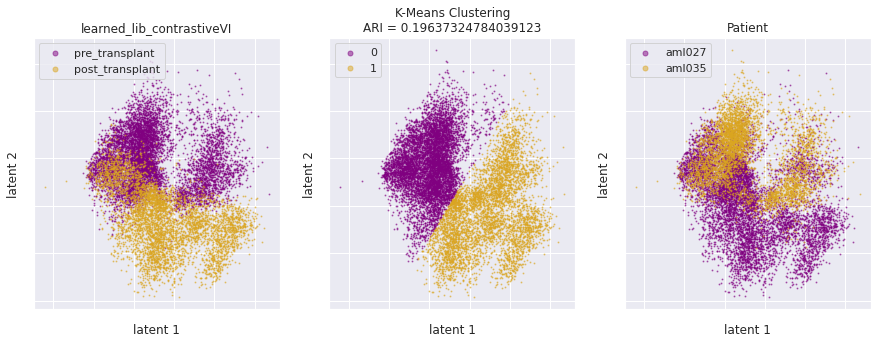

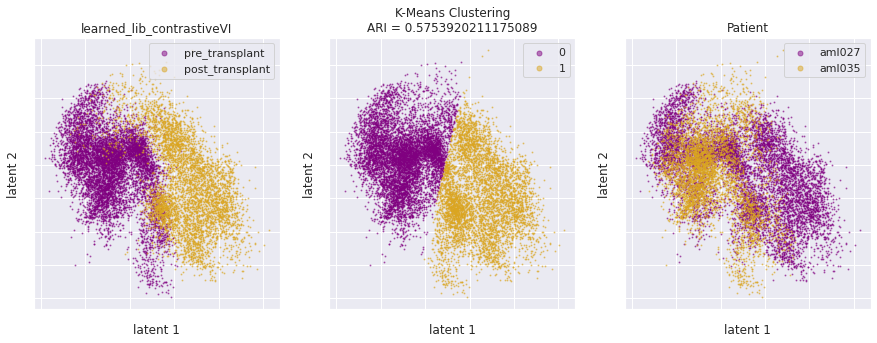

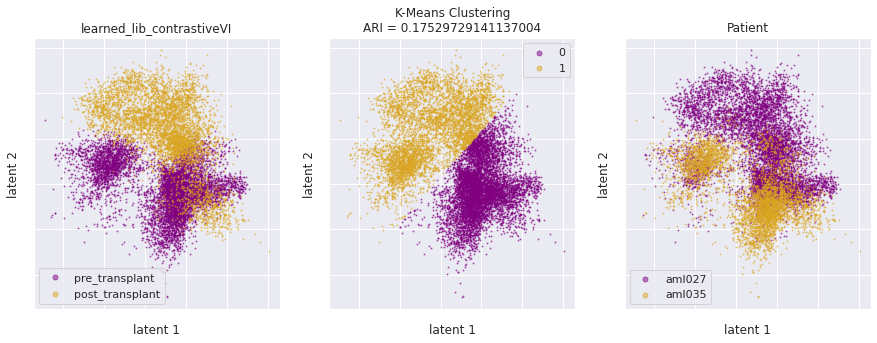

In [129]:
for seed_index in range(5):
    two_dim_dict = {
        "learned_lib_contrastiveVI": learned_lib_contrastive_vi_latent_representations[seed_index],
    }
    xlabel = "latent 1"
    ylabel = "latent 2"
    if latent_size > 2:
        for key, rep in two_dim_dict.items():
            two_dim_dict[key] = PCA().fit_transform(rep)[:, :2]
        xlabel = "PC1"
        ylabel = "PC2"

    target_labels = target_adata.obs["condition"]
    fix, axes = plt.subplots(figsize=(15, 5 * len(two_dim_dict)), ncols=3, nrows=len(two_dim_dict))
    colors = ["purple", "goldenrod"]
    
    for model_name, rep in two_dim_dict.items():
        ari = ari_results_dict[model_name][seed_index]
        
        ax = axes[0]
        for i, label in enumerate(target_labels.unique()):
            ax.scatter(
                rep[:, 0][target_labels == label],
                rep[:, 1][target_labels == label],
                s=1,
                label=label,
                color=colors[i],
                alpha=0.5,
            )
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.legend(markerscale=5)
        ax.set_title(model_name)
        
        ax = axes[1]
        clusters = latent_clusters_dict[model_name][seed_index]
        for i, cluster in enumerate(np.unique(clusters)):
            ax.scatter(
                rep[:, 0][clusters == cluster],
                rep[:, 1][clusters == cluster],
                s=1,
                label=cluster,
                color=colors[i],
                alpha=0.5,
            )
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.legend(markerscale=5)
        ax.set_title(f"K-Means Clustering\nARI = {ari}")
        
        ax = axes[2]
        patient_ids = target_adata.obs["patient_id"]
        for i, patient_id in enumerate(patient_ids.unique()):
            ax.scatter(
                rep[:, 0][patient_ids == patient_id],
                rep[:, 1][patient_ids == patient_id],
                s=1,
                label=patient_id,
                color=colors[i],
                alpha=0.5,
            )
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.legend(markerscale=5)
        ax.set_title("Patient")